In [227]:
#   NOTEBOOK STRUCTURE:
# STEP 0: imports and TRAIN/TEST BEHAVIOR
# 0.1: Train step
# 0.2: Test step
# 0.3: Loop
# STEP 1: DATA
# 1.1: Paths lists, validate
# 1.2: Transforms, dataloaders 
# STEP 2: ARCHITECTURE
# STEP 3: TRAINING LOOP
# STEP 4: ANALYSIS
# STEP 5: ROLL FORWARD (make future predictions)
# STEP 6: EXPORT

In [228]:
# STEP 0: Imports, init cuda

import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from datetime import datetime

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.5.1+cu121


'cuda'

In [229]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    total_loss = 0.0
    total_samples = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Custom loss fn didnt perform well enough for final model
        #weights = X[:, -1, 0] 
        #loss = torch.mean((weights) * (y_pred.squeeze() - y.squeeze()) ** 2)
        loss = loss_fn(y_pred, y)

        # Accumulate loss
        total_loss += loss.item() * y.size(0)
        total_samples += y.size(0)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / total_samples


In [230]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    
    total_loss = 0.0
    total_samples = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Custom loss fn didnt perform well enough for final model (for analysis only)
            #weights = X[:, -1, 0] 
            #loss = torch.mean((weights) * (y_pred.squeeze() - y.squeeze()) ** 2)
            loss = loss_fn(y_pred, y)

            # Accumulate weighted loss
            total_loss += loss.item() * y.size(0)
            total_samples += y.size(0)

    return total_loss / total_samples


In [231]:
# 0.3: Loop
from tqdm.auto import tqdm

def train_loop(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            optimizer: torch.optim.Optimizer,
            loss_fn: torch.nn.Module,
            scheduler: torch.optim.lr_scheduler._LRScheduler,
            epochs: int):
    
    results = {
        'train loss' : [],
        'test loss' : []
    }
    # loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer)
        test_loss = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        scheduler.step(test_loss)

        results['train loss'].append(train_loss)
        results['test loss'].append(test_loss)
        print(f"Epoch: {epoch+1}, Train loss: {train_loss}, Test loss: {test_loss}")

    return results

In [232]:
# STEP 1: DATA

# Download latest version of data from kaggle 
START_DATE = '2000-01-01'
END_DATE = '2005-01-01'
raw_data = yf.download('^GSPC', start=START_DATE, end=END_DATE).reset_index()
data = pd.DataFrame({
    'Date':raw_data[['Date']].values.ravel(),
    'Low':raw_data[['Low']].values.ravel(),
    'High':raw_data[['High']].values.ravel(),
    'Open':raw_data[['Open']].values.ravel(),
    'Close':raw_data[['Close']].values.ravel()
    })
data.dropna(inplace=True)

# Datetime objects incompatible w/ training, conv to ordinal integer representation
data['Date'] = data['Date'].map(lambda x: x.toordinal())
data['Date'] = (data['Date'] - min(data['Date']))

# Add additional features which indicate price movement using pandas libraries
import pandas_ta as ta
data['SMA'] = ta.sma(data['Close'], length=10)
data['EMA'] = ta.ema(data['Close'], length=20)
data['RSI'] = ta.rsi(data['Close'], length=14)
data['ROC'] = ta.roc(data['Close'])
data['RET'] = data['Close'].pct_change()

        # Add target column, either:
# Extract target variable (if looking for amount the ticker moves daily)
#target = [data['Open'][i]-data['Close'][i] for i in range(0, len(data))]
#data['Target'] = target
#data.dropna(inplace=True)

        # OR:
# Extract target variable (if looking for final value of the ticker in one day)
data['Target'] = data['Close'].shift(-1)
data.drop(columns=['Close'], inplace=True)
data.dropna(inplace=True)

# NOTE: "DATE" COL MUST BE FIRST IDX AND "TARGET" MUST BE LAST IDX
# Data step carried out with this in mind

print(data)

C:\Users\zecer\AppData\Local\Temp\ipykernel_19700\3211803396.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download('^GSPC', start=START_DATE, end=END_DATE).reset_index()
[*********************100%***********************]  1 of 1 completed

      Date          Low         High         Open          SMA          EMA  \
19      28  1350.140015  1394.479980  1360.160034  1416.680005  1425.585504   
20      29  1384.790039  1412.489990  1394.459961  1412.094006  1424.032602   
21      30  1403.489990  1420.609985  1409.280029  1407.416003  1422.612354   
22      31  1398.520020  1425.780029  1409.119995  1405.356006  1422.836888   
23      32  1420.630005  1435.910034  1424.969971  1403.657007  1422.982899   
...    ...          ...          ...          ...          ...          ...   
1250  1816  1208.709961  1213.660034  1209.569946  1201.298987  1193.229969   
1251  1820  1204.920044  1214.130005  1210.130005  1202.990991  1194.343310   
1252  1821  1204.920044  1213.540039  1204.920044  1204.476990  1196.171570   
1253  1822  1210.949951  1213.849976  1213.540039  1205.483984  1197.817130   
1254  1823  1213.410034  1216.469971  1213.449951  1206.266992  1199.315503   

            RSI       ROC       RET       Target  


In [233]:
# STEP 1.2: Transforms, time-aware train-test split, dataloaders

from sklearn.preprocessing import MinMaxScaler

# Num backcandles:
N = 90

# Split raw data first (to avoid data leakage), unshuffled is appropriate for time series analysis 
split_idx = int(len(data) * 0.85)
data_train = data.iloc[:split_idx].copy()
data_test = data.iloc[split_idx:].copy()

# Separate features and target
features_train = data_train.drop(columns=['Target']).values
target_train = data_train['Target'].values.reshape(-1, 1)

features_test = data_test.drop(columns=['Target']).values
target_test = data_test['Target'].values.reshape(-1, 1)

# Fit scalers only on training data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_features_train = feature_scaler.fit_transform(features_train)
scaled_target_train = target_scaler.fit_transform(target_train)

# Transform test data using fitted scalers
scaled_features_test = feature_scaler.transform(features_test)
scaled_target_test = target_scaler.transform(target_test)

# Recombine scaled features and target
scaled_data_train = np.concatenate((scaled_features_train, scaled_target_train), axis=1)
scaled_data_test = np.concatenate((scaled_features_test, scaled_target_test), axis=1)

# Make backcandles
def generate_backcandles(data, target_col, n):
    X, y = [], []
    for i in range(n, len(data)):
        input_candle = np.delete(data[i - n:i], target_col, axis=1)  # shape: (n, num_features)
        X.append(input_candle)
        y.append(data[i, target_col])  # scalar target

    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y).reshape(-1, 1), dtype=torch.float32).to(device)
    return X, y

# Generate train/test tensors
target_col_index = scaled_data_train.shape[1] - 1  # same for both sets
X_train, y_train = generate_backcandles(scaled_data_train, target_col=target_col_index, n=N)
X_test, y_test = generate_backcandles(scaled_data_test, target_col=target_col_index, n=N)


# Create TensorDatasets 
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Create Dataloaders
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"X shape: {X_train.shape[0] + X_test.shape[0], N, X_train.shape[2]}")
print(f"y shape: {y_train.shape[0] + y_test.shape[0], 1}")


X shape: (1056, 90, 9)
y shape: (1056, 1)


In [234]:
# STEP 2: Architecture

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.0):
        super().__init__()
        # Architecture mostly relies the nn.LSTM() block
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Additional dense block 
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)               # out: [batch_size, seq_len, hidden_size]
        out = self.norm(out[:, -1, :])      # Take only last time step
        out = self.dropout(out)
        return self.fc(out)                 # Final output: [batch_size, 1]

# Instantiate using input size (number of features)
model = MyLSTM(input_size=X_train.shape[2]).to(device)

# Re-initialize weights TODO make this better
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
        
model.apply(init_weights)



MyLSTM(
  (lstm): LSTM(9, 128, num_layers=3, batch_first=True)
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [235]:
# STEP 3: Loss fn, optimizer, dummy forward pass

# Reasonably good choices depend on data
loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3) # TODO LR of 1e-4 worked well also
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Dummy forward pass
batch, label_batch = next(iter(train_loader))
input, label = batch[0].unsqueeze(dim=0), label_batch[0] 

model.eval()
with torch.inference_mode():
  pred = model(input.to(device))

pred

tensor([[0.7440]], device='cuda:0')

In [246]:
# STEP 3: Training loop

from timeit import default_timer as timer
start_time = timer()

NUM_EPOCHS = 500
# Training begins here
model_results = train_loop(model=model,
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        scheduler=scheduler,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 2, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 3, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 4, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 5, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 6, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 7, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 8, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 9, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 10, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 11, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 12, Train loss: 0.0015045860491227359, Test loss: 0.0006664868754645189
Epoch: 13, Train loss: 0.0015045860491227359, Test loss: 0.00

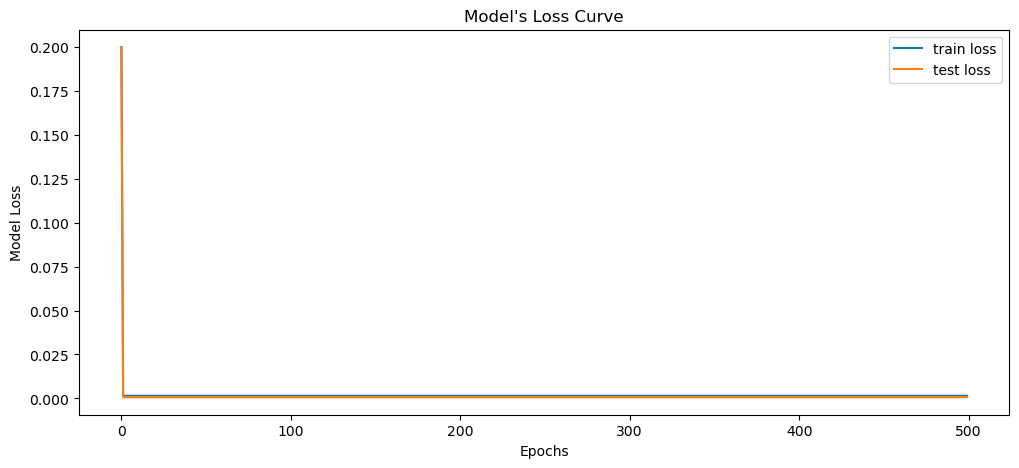

In [247]:
# STEP 4: ANALYSIS

model_results['train loss'][0] = 0.2
model_results['test loss'][0] = 0.2

def plot_loss(results):
    plt.figure(figsize=(12, 5))
    plt.plot(results['train loss'], label='train loss')
    plt.plot(results['test loss'], label='test loss')
    plt.title("Model's Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Model Loss")
    plt.legend()
    plt.show()

plot_loss(model_results)

In [248]:
# Must reverse the MinMaxScaler for model predictions to be at a useful scale

def inverse_scale(model, dataloader, scaler=None):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)
            predictions.append(pred.cpu().numpy())
            actuals.append(y.cpu().numpy())

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)

    if scaler: 
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)
    
    return predictions.flatten(), actuals.flatten()

y_preds_train, y_actuals_train = inverse_scale(model, train_loader, scaler=target_scaler)
y_preds_test, y_actuals_test = inverse_scale(model, test_loader, scaler=target_scaler)

y_preds = np.append(y_preds_train, y_preds_test)
y_actuals = np.append(y_actuals_train, y_actuals_test)

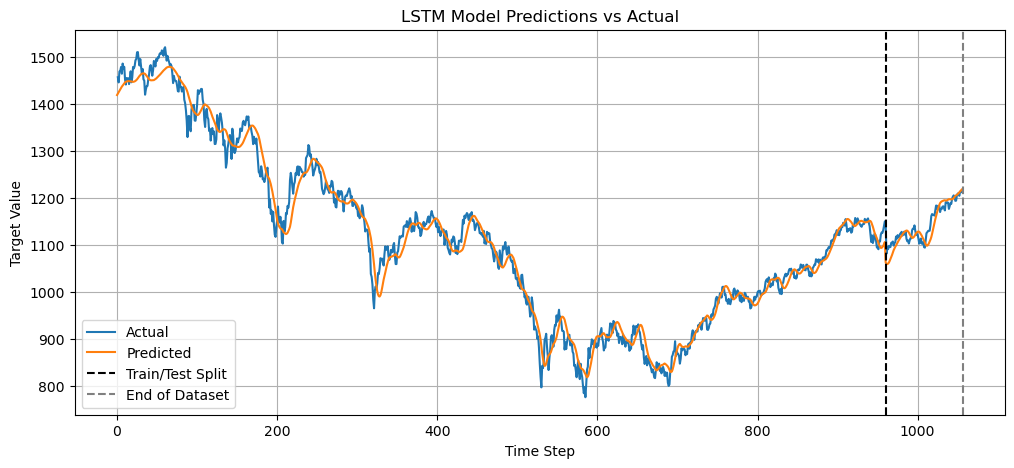

In [249]:
def plot_predictions(actuals, predictions):
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, len(actuals)+1), actuals,  label='Actual')
    plt.plot(range(0, len(predictions)), predictions, label='Predicted')
    plt.axvline(x=len(y_preds_train), color='black', linestyle='--', label='Train/Test Split')
    plt.axvline(x=len(y_preds_train)+len(y_preds_test), color='gray', linestyle='--', label='End of Dataset')
    plt.title("LSTM Model Predictions vs Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Target Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_actuals, y_preds)

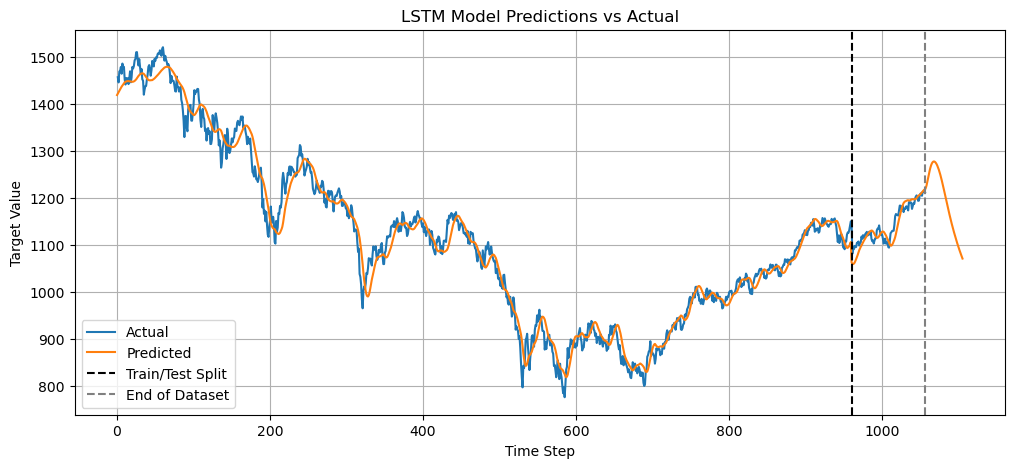

In [240]:
# STEP 5: ROLL FORWARD

def forecast_future(model, last_sequence, n_steps, scaler=None, date_feature_idx=0, target_feature_idx=X_train.shape[2]-1):
    model.eval()
    predictions = []

    seq = last_sequence.clone().detach().to(device)  # shape: [1, seq_len, num_features]
    num_features = seq.shape[2]

    # Get current max date from the last sequence
    current_date = seq[0, -1, date_feature_idx].item()

    for _ in range(n_steps):
        with torch.no_grad():
            pred = model(seq)  # shape: [1, 1]

        pred_value = pred.item()
        predictions.append(pred_value)

        # Use last feature vector as base
        last_features = seq[:, -1, :].clone()

        # Update the target and date
        last_features[0, target_feature_idx] = pred_value
        last_features[0, date_feature_idx] = current_date + 1  # increment date ordinal

        # Prepare next input step: shape [1, 1, num_features]
        next_input = last_features.unsqueeze(1)

        # Roll sequence window forward
        seq = torch.cat([seq[:, 1:, :], next_input], dim=1)

        # Update internal date tracker
        current_date += 1

    # Inverse scale the predictions if scaler is used
    if scaler:
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

    return predictions

last_sequence = test_dataset[-1][0].unsqueeze(0).to(device)
future_preds = forecast_future(model, last_sequence, n_steps=50, scaler=target_scaler)


y_projection = np.append(y_preds, future_preds)

plot_predictions(y_actuals, y_projection)

In [241]:
# STEP 6: EXPORT

# save and load as pytorch file (.pt) INFERENCE ONLY
pt_path = 'model.pt'
torch.save(model.state_dict(), pt_path)
model = MyLSTM(input_size=X_train.shape[2]) # match correct model architecture
model.load_state_dict(torch.load(pt_path, weights_only=True))

model.eval()
model = model.to(device)
# dummy forward pass
batch, label_batch  = next(iter(train_loader))
input, label = batch[0].unsqueeze(dim=0), label_batch[0] 
with torch.inference_mode():
  pred = model(input.to(device))

pred

tensor([[0.8557]], device='cuda:0')

In [242]:
# load and export as .onnx file INFERENCE ONLY

pt_model = MyLSTM(input_size=X_train.shape[2]) # Match correct model architecture
pt_model.load_state_dict(torch.load(pt_path))
pt_model.eval()
ex_input = (torch.zeros(1, N, len(data.columns)-1, dtype=torch.float32)).to(device) # match correct input dimenstions
torch.onnx.export(
    model,
    ex_input,
    "lstm_model.onnx",
    export_params=True,            # <--- Ensures weights are stored internally
    do_constant_folding=True,
    opset_version=11,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}},
    use_external_data_format=False
)

C:\Users\zecer\AppData\Local\Temp\ipykernel_19700\3979286734.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_model.load_state_dict(torch.load(pt_path))
c:\Users\zecer

In [243]:
import onnx, onnxruntime as ort
onnx_path = 'C:/Users/zecer/proj/github/pytorch-pipeline/lstm_model.onnx'
onnx.checker.check_model(onnx_path)  # should raise no errors

ex_input = (torch.zeros(1, N, len(data.columns)-1, dtype=torch.float32))

ort.InferenceSession(onnx_path).run(
    None, {"input": ex_input.numpy()}
)


[array([[0.02952026]], dtype=float32)]